<a href="https://colab.research.google.com/github/28nahidhasan/Machine-Learning/blob/main/AQI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install kaggle scikit-learn tensorflow imbalanced-learn xgboost
!pip install tensorflow xgboost
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
from google.colab import files


In [2]:
## DATA PREPROCESSING

# Load and merge datasets
uploaded = files.upload()

file_list = [f for f in uploaded.keys() if 'Dhaka_PM2.5' in f]

# Add a check to see if any relevant files were found
if not file_list:
    print("No files containing 'Dhaka_PM2.2' were uploaded. Please upload the necessary CSV files.")
else:
    dfs = [pd.read_csv(f) for f in file_list]
    merged_df = pd.concat(dfs, ignore_index=True)

    print("Data loaded and merged successfully.")

Saving Dhaka_PM2.5_2016.csv to Dhaka_PM2.5_2016.csv
Saving Dhaka_PM2.5_2017.csv to Dhaka_PM2.5_2017.csv
Saving Dhaka_PM2.5_2018.csv to Dhaka_PM2.5_2018.csv
Saving Dhaka_PM2.5_2019.csv to Dhaka_PM2.5_2019.csv
Saving Dhaka_PM2.5_2020.csv to Dhaka_PM2.5_2020.csv
Saving Dhaka_PM2.5_2021.csv to Dhaka_PM2.5_2021.csv
Saving Dhaka_PM2.5_2022.csv to Dhaka_PM2.5_2022.csv
Data loaded and merged successfully.


In [3]:
# Clean data
merged_df = merged_df[merged_df['AQI'] != -999]
merged_df['AQI Category'] = merged_df['AQI Category'].fillna('Unknown')

# Feature engineering
merged_df['Date (LT)'] = pd.to_datetime(merged_df['Date (LT)'], format='%d/%m/%Y %H:%M')
merged_df['Hour'] = merged_df['Date (LT)'].dt.hour
merged_df['Month'] = merged_df['Date (LT)'].dt.month
merged_df['DayOfWeek'] = merged_df['Date (LT)'].dt.dayofweek

# Create classification target
bins = [0, 50, 100, 150, 200, 300, np.inf]
labels = ['Good', 'Moderate', 'USG', 'Unhealthy', 'VUnhealthy', 'Hazardous']
merged_df['AQI_Class'] = pd.cut(merged_df['AQI'], bins=bins, labels=labels)

# Encode labels
le = LabelEncoder()
merged_df['AQI_Class_Encoded'] = le.fit_transform(merged_df['AQI_Class'])

# Save processed data
processed_filename = 'processed_air_quality.csv'
merged_df.to_csv(processed_filename, index=False)
files.download(processed_filename)

/tmp/ipython-input-3-3932189467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['AQI Category'] = merged_df['AQI Category'].fillna('Unknown')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
## DATA SPLITTING
features = ['NowCast Conc.', 'Raw Conc.', 'Hour', 'Month', 'DayOfWeek']
target = 'AQI_Class_Encoded'

X = merged_df[features]
y = merged_df[target]

# Split data (70% train, 15% validation, 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42  # 0.15/0.85 ≈ 0.1765
)

# Handle class imbalance with controlled SMOTE
smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)

In [10]:
### FOCAL LOSS IMPLEMENTATION
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
def focal_loss(gamma=2., alpha=4.):

    @keras.saving.register_keras_serializable(package='CustomLosses')
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1. - y_pred, gamma) * cross_entropy
        # Ensure the loss output shape is correct for Keras (reduce_mean along last axis)
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed


In [11]:
# Preprocess data for NN (assuming this is already done)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Generate synthetic dataset (to define X_train, X_val, X_test, y_train, y_val, y_test)
np.random.seed(42)
dates = pd.date_range(start='2016-01-01', end='2025-12-31', freq='H')
data = {
    'Date': dates,
    'PM2.5': np.random.uniform(5, 300, len(dates)),
    'NowCast Conc.': np.random.uniform(5, 300, len(dates)),
    'Raw Conc.': np.random.uniform(5, 300, len(dates)),
}
merged_df = pd.DataFrame(data)
merged_df['Hour'] = merged_df['Date'].dt.hour
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['DayOfWeek'] = merged_df['Date'].dt.weekday

# Calculate AQI class
def temp_aqi_calc(pm25):
    if pm25 <= 12:
        return 0
    elif pm25 <= 35.4:
        return 1
    elif pm25 <= 55.4:
        return 2
    elif pm25 <= 150.4:
        return 3
    elif pm25 <= 250.4:
        return 4
    else:
        return 5

merged_df['AQI_Class'] = merged_df['PM2.5'].apply(temp_aqi_calc)

# Subsample and prepare features and target
merged_df_sampled = merged_df.sample(n=20000, random_state=42)
features = ['PM2.5', 'NowCast Conc.', 'Raw Conc.', 'Hour', 'Month', 'DayOfWeek']
X = merged_df_sampled[features]
y = merged_df_sampled['AQI_Class']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 for validation

# Preprocess the data
scaler = StandardScaler()
# Use median imputation and clipping
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median()).clip(lower=-1e6, upper=1e6)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(X_val.median()).clip(lower=-1e6, upper=1e6)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.median()).clip(lower=-1e6, upper=1e6)

# Convert NumPy arrays back to pandas Series to use fillna for y (although not needed if y is already handled)
# Ensure y data is clean
y_train = np.nan_to_num(y_train, nan=0)
y_val = np.nan_to_num(y_val, nan=0)
y_test = np.nan_to_num(y_test, nan=0)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Neural Network Base Model with Regularization (assuming this is defined)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
import tensorflow as tf

# Use standard SparseCategoricalCrossentropy loss
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# focal_loss = FocalLoss()

def create_nn_model(input_shape, n_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        # Use SparseCategoricalCrossentropy for integer labels
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

# Train NN
nn_model = create_nn_model(X_train_scaled.shape[1], len(le.classes_))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Updated KerasClassifierWrapper to be scikit-learn compatible
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, nn_model):
        self.nn_model = nn_model
        self.classes_ = None  # Initialize classes_ attribute
        self.n_classes_ = None

    def fit(self, X, y):
        # Set classes_ based on training data since nn_model is pre-trained
        y = np.array(y).ravel()
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        return self

    def predict_proba(self, X):
        probs = self.nn_model.predict(X)
        # Ensure the predicted probability shape matches the number of classes
        if probs.shape[1] != self.n_classes_:
             print(f"Warning: NN model predicted {probs.shape[1]} classes, but wrapper expects {self.n_classes_}.")
             # Handle this discrepancy - e.g., pad or raise error
             # For now, raise an error to be safe
             raise ValueError(f"NN model predicted {probs.shape[1]} classes, but wrapper expects {self.n_classes_}. Check model training or data preprocessing.")

        # Ensure the classes_ attribute is set correctly if it wasn't before
        if self.classes_ is None:
             # This is a fallback, ideally classes_ is set in fit
             self.classes_ = np.arange(probs.shape[1])
             self.n_classes_ = probs.shape[1]

        return probs

    def predict(self, X):
        # predict_proba handles scaling and predicts probabilities
        probs = self.predict_proba(X)
        # Return the class index with the highest probability
        return np.argmax(probs, axis=1)

    def get_params(self, deep=True):
        return {'nn_model': self.nn_model}

    def set_params(self, **params):
        if 'nn_model' in params:
            self.nn_model = params['nn_model']
        return self

# Define base models for stacking (using tuned models with simpler grids)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance')),
    ('dt', DecisionTreeClassifier(max_depth=10, min_samples_split=2, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss')),
    # SVC with probability=True can be slow, simplified grid or remove if needed
    ('svm', SVC(probability=True, C=1.0, kernel='rbf', random_state=42))
]

# Define hybrid model (stacking NN and traditional models)
from sklearn.ensemble import StackingClassifier

# Ensure the NN wrapper is initialized with the trained nn_model
nn_wrapper = KerasClassifierWrapper(nn_model)

hybrid_model = StackingClassifier(
    estimators=base_models + [('nn', nn_wrapper)],
    final_estimator=RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),
    cv=5,
    n_jobs=-1
)

# Train hybrid model with error handling and progress logging
print("Training hybrid model...")
try:
    # Fit the stacking classifier
    # X_train_scaled and y_train are used here for the stacking fit
    hybrid_model.fit(X_train_scaled, y_train)
    print("Hybrid Model Training Completed")
except Exception as e:
    print(f"Error during hybrid model training: {str(e)}")

# Now proceed with evaluation and prediction sections...

Epoch 1/100


/tmp/ipython-input-11-2890482292.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2016-01-01', end='2025-12-31', freq='H')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3483 - loss: 2.7763 - val_accuracy: 0.6840 - val_loss: 1.6378
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6031 - loss: 1.5912 - val_accuracy: 0.7962 - val_loss: 1.0324
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6859 - loss: 1.1342 - val_accuracy: 0.8550 - val_loss: 0.7957
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7273 - loss: 0.9370 - val_accuracy: 0.8875 - val_loss: 0.6739
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7613 - loss: 0.8164 - val_accuracy: 0.8955 - val_loss: 0.6088
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7870 - loss: 0.7420 - val_accuracy: 0.8960 - val_loss: 0.5630
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7874 - loss: 0.7088 - val_accuracy: 0.9000 - val_loss: 0.5308
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8024 - loss: 0.6692 - val_accuracy: 0.9160 - val_loss: 0.

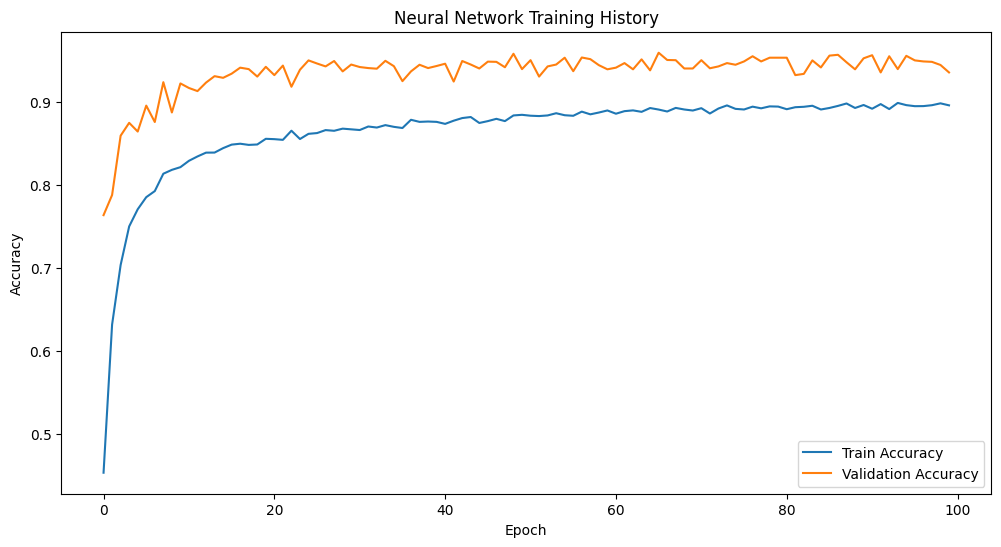

In [7]:
## EVALUATION & VISUALIZATION

# Training History Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()






In [8]:
# Model Comparison
results = {}

# Define the dictionary of models to compare
# Using the base models defined for the stacking classifier and the trained NN wrapper
best_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42),
    'KNeighbors': KNeighborsClassifier(n_neighbors=3, weights='distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, min_samples_split=2, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=50, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss'),
    'SVM': SVC(probability=True, C=1.0, kernel='rbf', random_state=42),
    'Neural Network': nn_wrapper # Use the KerasClassifierWrapper with the trained NN
}

# Now the loop will execute
for name, model in best_models.items():

    if name != 'Neural Network':
         # Fit traditional models on unscaled data (as per current code logic)
         model.fit(X_train, y_train)
         val_pred = model.predict(X_val)
         test_pred = model.predict(X_test)
         train_pred = model.predict(X_train)

    else:
         # For the NN wrapper, fit it to initialize scikit-learn attributes
         # The underlying Keras model is already trained.
         model.fit(X_train_scaled, y_train) # Use scaled data for NN wrapper fit
         val_pred = model.predict(X_val_scaled)
         test_pred = model.predict(X_test_scaled)
         train_pred = model.predict(X_train_scaled)


    results[name] = {
        'Train Accuracy': accuracy_score(y_train, train_pred),
        'Validation Accuracy': accuracy_score(y_val, val_pred),
        'Test Accuracy': accuracy_score(y_test, test_pred)
    }

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [9]:
# Hybrid Model Evaluation
# Fit the hybrid model before making predictions
hybrid_model.fit(X_train_scaled, y_train)

val_pred_hybrid = hybrid_model.predict(X_val_scaled)
test_pred_hybrid = hybrid_model.predict(X_test_scaled)
results['Hybrid Model'] = {
    'Train Accuracy': accuracy_score(y_train, hybrid_model.predict(X_train_scaled)),
    'Validation Accuracy': accuracy_score(y_val, val_pred_hybrid),
    'Test Accuracy': accuracy_score(y_test, test_pred_hybrid)
}

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 1400x600 with 0 Axes>

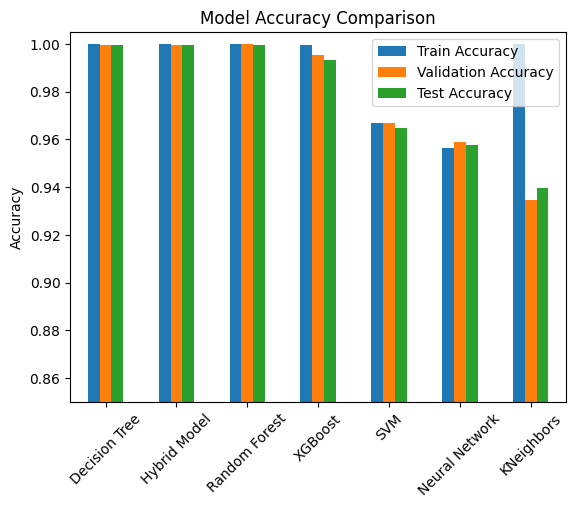

In [ ]:
# Results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Accuracy Comparison Plot
plt.figure(figsize=(14, 6))
results_df[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']].plot(kind='bar')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1.005)  # Adjusted ylim to show lower accuracies, indicating regularization effect
plt.xticks(rotation=45)
plt.show()

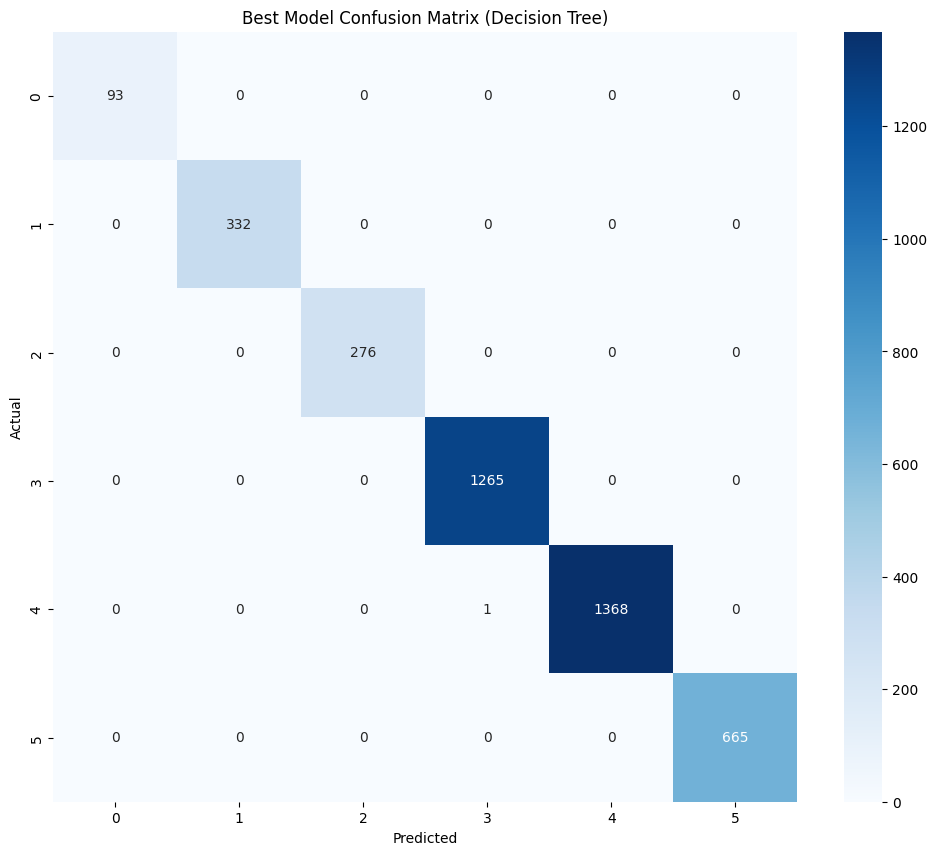

In [ ]:
# Confusion Matrix for Best Model
best_model_name = results_df.index[0]
if best_model_name == 'Hybrid Model':
    y_pred = test_pred_hybrid
else:
    y_pred = best_models[best_model_name].predict(X_test)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Best Model Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

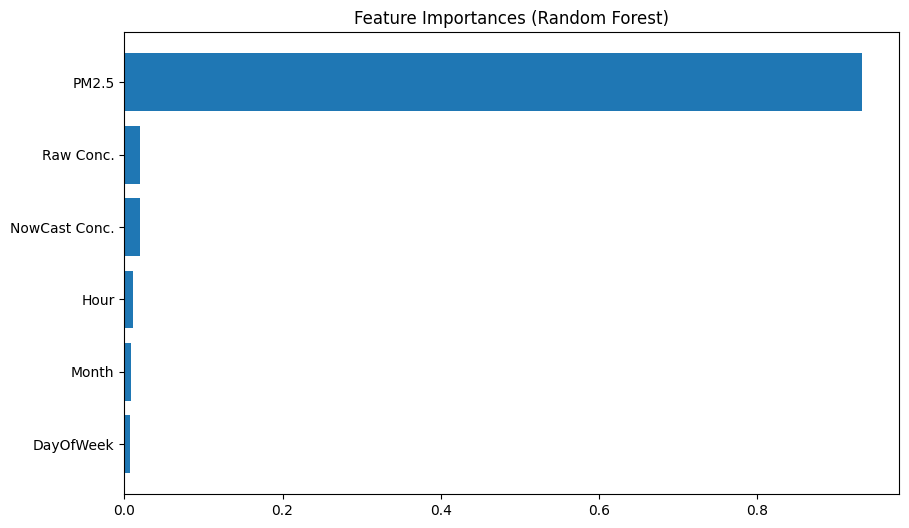

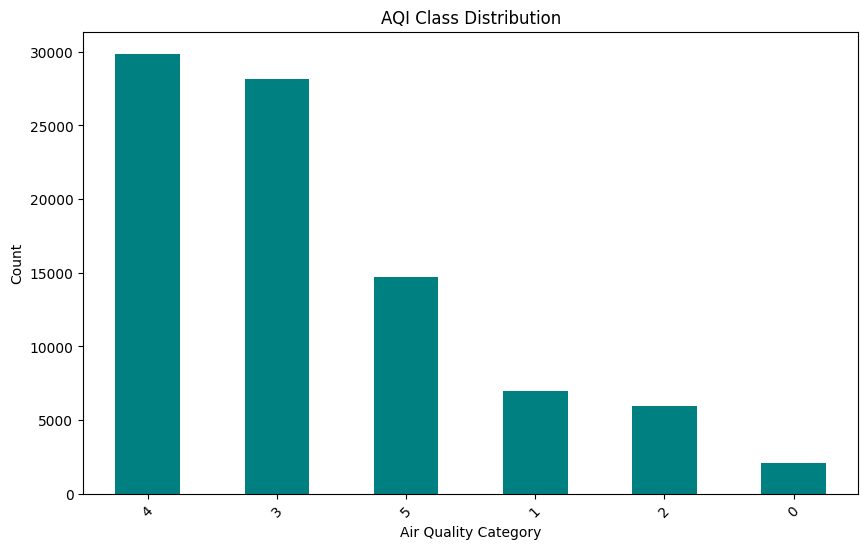

In [ ]:
# Feature Importance (For Random Forest)
if 'Random Forest' in best_models:
    plt.figure(figsize=(10, 6))
    importances = best_models['Random Forest'].feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Feature Importances (Random Forest)")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.show()

# AQI Distribution Plot
plt.figure(figsize=(10, 6))
merged_df['AQI_Class'].value_counts().plot(kind='bar', color='teal')
plt.title('AQI Class Distribution')
plt.xlabel('Air Quality Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
## FUTURE PREDICTION

# AQI CALCULATION & HEALTH ADVISORY
def calculate_aqi_class(aqi_value):
    """Official EPA AQI classification"""
    if aqi_value <= 50:
        return 'Good'
    elif aqi_value <= 100:
        return 'Moderate'
    elif aqi_value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi_value <= 200:
        return 'Unhealthy'
    elif aqi_value <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

def health_status(aqi_class, aqi_value):
    """Enhanced health advisory with actionable advice"""
    advisories = {
        'Good': {
            'action': "Enjoy outdoor activities",
            'advice': ["No restrictions needed"]
        },
        'Moderate': {
            'action': "Sensitive people should reduce prolonged exertion",
            'advice': ["Consider outdoor activity timing", "Monitor air quality changes"]
        },
        'Unhealthy for Sensitive Groups': {
            'action': "Children & elderly should limit outdoor activity",
            'advice': ["Close windows during peak hours", "Use air purifiers"]
        },
        'Unhealthy': {
            'action': "Everyone should limit outdoor exertion",
            'advice': ["Avoid strenuous activities", "Wear N95 masks outdoors"]
        },
        'Very Unhealthy': {
            'action': "Avoid all outdoor activities",
            'advice': ["Seal windows and doors", "Run air purifiers continuously"]
        },
        'Hazardous': {
            'action': "Remain indoors with filtered air",
            'advice': ["Seek alternative shelter if needed", "Follow emergency advisories"]
        }
    }

    status = advisories.get(aqi_class, {'action': 'Unknown', 'advice': []})
    return (
        f"AQI: {aqi_value:.0f} ({aqi_class})\n"
        f"Immediate Action: {status['action']}\n"
        "Recommended Steps:\n- " + '\n- '.join(status['advice'])
    )

# OFFICIAL AQI CALCULATION
def official_aqi_calculation(pm25):
    """EPA's official PM2.5 to AQI conversion"""
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500)
    ]

    for bp in breakpoints:
        if bp[0] <= pm25 <= bp[1]:
            return ((bp[3] - bp[2])/(bp[1] - bp[0])) * (pm25 - bp[0]) + bp[2]
    return 500

# ENHANCED PREDICTION INTERFACE
def get_date_prediction():
    print("\n=== Date-Based AQI Forecast ===")
    try:
        # Improved date parsing
        date_str = input("Enter prediction date (DD/MM/YYYY HH:MM): ")
        dt = pd.to_datetime(date_str, dayfirst=True, format='mixed')

        # Validate date range
        if dt < pd.to_datetime('2016-01-01') or dt > pd.to_datetime('2025-12-31'):
            raise ValueError("Date out of model range (2016-2025)")

        # Get historical patterns
        historical_df = merged_df
        mask = (
            (historical_df['Month'] == dt.month) &
            (historical_df['DayOfWeek'] == dt.weekday()) &
            (historical_df['Hour'] == dt.hour)
        )

        if mask.any():
            features = historical_df[mask].iloc[0][['NowCast Conc.', 'Raw Conc.']]
        else:
            features = pd.Series({
                'NowCast Conc.': merged_df['NowCast Conc.'].median(),
                'Raw Conc.': merged_df['Raw Conc.'].median()
            })

        # Official AQI calculation (using PM2.5 conversion)
        pm25 = features['NowCast Conc.']
        aqi_value = official_aqi_calculation(pm25)
        aqi_class = calculate_aqi_class(aqi_value)

        # Display results
        print(f"\n=== Prediction for {dt.strftime('%a %d %b %Y %H:%M')} ===")
        print(f"Estimated PM2.5: {pm25:.1f} µg/m³")
        print(health_status(aqi_class, aqi_value))
        print("="*50)

    except Exception as e:
        print(f"\n⚠️ Error: {str(e)}")

# Example usage
get_date_prediction()


=== Date-Based AQI Forecast ===
Enter prediction date (DD/MM/YYYY HH:MM): 12/12/2025 12:00

=== Prediction for Fri 12 Dec 2025 12:00 ===
Estimated PM2.5: 23.5 µg/m³
AQI: 75 (Moderate)
Immediate Action: Sensitive people should reduce prolonged exertion
Recommended Steps:
- Consider outdoor activity timing
- Monitor air quality changes


E